# dev - John Ragland

## I'm playing around to create a quick script to DAS to Zarr

- specifically trying to get this experiment into zarr: http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/

- chunk size is arbitrarily chosen to be {'time':3000, 'distance':3000}
- quick back of the envelope calculations: (single file experimented with)
    - Dataset should be ~ 4.659 TB stored in hdf5
    - Dataset should be ~ ___ TB stored in zarr
    
    
- I'm implementing this in xarray because that's what I know how to use better. I'm not sure if this is causing a significant increase in time or not.

In [20]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import h5py
from tqdm import tqdm
from multiprocessing.pool import Pool

from dask.distributed import Client

In [21]:
client = Client()
client

/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41293 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:41293/status,
Dashboard: http://127.0.0.1:41293/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34555,Workers: 8
Dashboard: http://127.0.0.1:41293/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:32953,Total threads: 4
Dashboard: http://127.0.0.1:37215/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:33207,


### Single File Test

In [3]:
f = h5py.File('/das_data/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231514Z.h5', 'r')

In [4]:
f['Acquisition']['Custom']

<HDF5 group "/Acquisition/Custom" (0 members)>

In [5]:
f['Acquisition']['Raw[0]']['RawData']

<HDF5 dataset "RawData": shape (47500, 12000), type "<i4">

In [6]:
# Let's just create a single file zarr

ds = xr.Dataset({
    'RawData':((['distance', 'time'], f['Acquisition']['Raw[0]']['RawData'][:])),
    'RawDataTime':('time', f['Acquisition']['Raw[0]']['RawDataTime'][:]),
    'GpBits':('time', f['Acquisition']['Raw[0]']['Custom']['GpBits']),
    'GpsStatus':('time', f['Acquisition']['Raw[0]']['Custom']['GpsStatus']),
    'PpsOffset':('time', f['Acquisition']['Raw[0]']['Custom']['PpsOffset']),
    'SampleCount':('time', f['Acquisition']['Raw[0]']['Custom']['SampleCount'])}
)

In [7]:
ds = ds.chunk({'time':3000, 'distance':3000})

In [8]:
fn = 'test.zarr'

ds.to_zarr(fn)

In [9]:
ds

<xarray.Dataset>
Dimensions:      (distance: 47500, time: 12000)
Dimensions without coordinates: distance, time
Data variables:
    RawData      (distance, time) int32 dask.array<chunksize=(3000, 3000), meta=np.ndarray>
    RawDataTime  (time) int64 dask.array<chunksize=(3000,), meta=np.ndarray>
    GpBits       (time) uint8 dask.array<chunksize=(3000,), meta=np.ndarray>
    GpsStatus    (time) uint8 dask.array<chunksize=(3000,), meta=np.ndarray>
    PpsOffset    (time) uint32 dask.array<chunksize=(3000,), meta=np.ndarray>
    SampleCount  (time) int64 dask.array<chunksize=(3000,), meta=np.ndarray>

### General Flow of script

For now, most of this process (except for actually writing the zarr uses just a single core)
I spent a little bit of time trying to open the file with fsspec (see section below) and not have to download the file to local disk but couldn't get it working.

- download single file to local disk
- read into RAM
- construct xr.Dataset
- append to zarr store
- delete single file from local disk

### Build Script

In [3]:
# setup access to Azure Storage
storage_options = {'account_name':'dasdata', 'account_key':os.environ['AZURE_KEY_dasdata']}
#ds = xr.open_zarr('abfs://zarr/SouthCable_Tx.zarr', storage_options=storage_options)

In [4]:
baseurl = url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/'

with open('file_list.txt') as f:
    fs = f.readlines()
    
files = []

for f in fs:
    files.append(f[:-1])

In [ ]:
first_loop = True

for file in tqdm(files, position=0, leave=True):
    print('download file...', end="\r")
    os.system(f'aria2c -q {baseurl + file}')
    
    print('read data into memory and construct xr.Dataset ...', end="\r")
    hf = h5py.File(file)
    
    ds = xr.Dataset({
        'RawData':((['distance', 'time'], hf['Acquisition']['Raw[0]']['RawData'][:])),
        'RawDataTime':('time', hf['Acquisition']['Raw[0]']['RawDataTime'][:]),
        'GpBits':('time', hf['Acquisition']['Raw[0]']['Custom']['GpBits']),
        'GpsStatus':('time', hf['Acquisition']['Raw[0]']['Custom']['GpsStatus']),
        'PpsOffset':('time', hf['Acquisition']['Raw[0]']['Custom']['PpsOffset']),
        'SampleCount':('time', hf['Acquisition']['Raw[0]']['Custom']['SampleCount'])}
    )
    
    print('write to zarr...                                    ', end="\r")
    # create new zarr store if beginning of loop otherwize, append in time dimension
    if first_loop:
        first_loop = False
        ds.to_zarr('abfs://zarr/SouthCable_Tx.zarr', storage_options=storage_options, mode='w-')
    else:
        ds.to_zarr('abfs://zarr/SouthCable_Tx.zarr', storage_options=storage_options, append_dim='time')
    
    # delete downloaded file
    os.system(f'rm {file}')

In [6]:
baseurl + file

'http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.h5'

### Modify Scripts for local operation

In [3]:
file_dir = '/das_data/h5files/'
file_list = os.listdir(file_dir)

# remove .aria2 files (only for debugging during transfer)
valid_idx = []
for k, file in enumerate(file_list):
    if file[-2] != 'a':
        valid_idx.append(k)
        
file_list = [file_list[i] for i in valid_idx]
file_list.sort()

files = [file_dir+file for file in file_list]

In [ ]:
first_loop=True

for file in tqdm(files):
    hf = h5py.File(file)
    
    ds = xr.Dataset({
        'RawData':((['distance', 'time'], hf['Acquisition']['Raw[0]']['RawData'][:])),
        'RawDataTime':('time', hf['Acquisition']['Raw[0]']['RawDataTime'][:]),
        'GpBits':('time', hf['Acquisition']['Raw[0]']['Custom']['GpBits']),
        'GpsStatus':('time', hf['Acquisition']['Raw[0]']['Custom']['GpsStatus']),
        'PpsOffset':('time', hf['Acquisition']['Raw[0]']['Custom']['PpsOffset']),
        'SampleCount':('time', hf['Acquisition']['Raw[0]']['Custom']['SampleCount'])}
    )
    
    ds = ds.chunk({'time':3000, 'distance':3000})
    
    # create new zarr store if beginning of loop otherwize, append in time dimension
    if first_loop:
        first_loop = False
        ds.to_zarr(f'/das_data/SouthCable_Tx_{files[0][-21:-4]}{files[-1][-21:-4]}', mode='w-')
    else:
        ds.to_zarr(f'/das_data/SouthCable_Tx_{files[0][-21:-4]}{files[-1][-21:-4]}', append_dim='time')


#### Try to parallelize read in

In [17]:
def create_ds(fn):
    '''
    create_ds - create an xr.DataSet from single .h5 file
    
    Paramaeters
    -----------
    fn : string
        absolute file location of h5 file
        
    Returns
    -------
    ds : xr.Dataset
        xarray dataset with data from file
    '''
    hf = h5py.File(fn)
    
    ds = xr.Dataset({
        'RawData':((['distance', 'time'], hf['Acquisition']['Raw[0]']['RawData'][:])),
        'RawDataTime':('time', hf['Acquisition']['Raw[0]']['RawDataTime'][:]),
        'GpBits':('time', hf['Acquisition']['Raw[0]']['Custom']['GpBits']),
        'GpsStatus':('time', hf['Acquisition']['Raw[0]']['Custom']['GpsStatus']),
        'PpsOffset':('time', hf['Acquisition']['Raw[0]']['Custom']['PpsOffset']),
        'SampleCount':('time', hf['Acquisition']['Raw[0]']['Custom']['SampleCount'])}
    )
    
    return ds
    

In [18]:
# protect the entry point
if __name__ == '__main__':
    # create and configure the process pool
    with Pool(32) as pool:
        # execute tasks in order
        dss = pool.map(create_ds, files[:32])

2023-01-04 23:30:46,061 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,061 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,061 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,061 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,062 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,062 - distributed.nanny - ERROR - Worker process died unexpectedly
2023-01-04 23:30:46,062 - distributed.nanny - ERROR - Worker process died unexpectedly
Exception in thread Nanny stop queue watch:
Traceback (most recent call last):
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/threading.py", line 1009, in _bootstrap_inner
    self.run()
  File "/home/jhrag/anaconda3/envs/ooi_dev/lib/python3.10/threading.py", line 946, in run
2023-01-04 23:30:46,063 - distributed.nanny - ERROR - Worker process died unexpectedly
    self._target

In [ ]:
dss

### Look at zarr store

In [22]:
import xarray as xr
import os
import hvplot.xarray
import pandas as pd
import numpy as np
import h5py
from dask.distributed import Client
storage_options = {'account_name':'dasdata', 'account_key':os.environ['AZURE_KEY_dasdata']}

In [23]:
client = Client()

In [24]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35183,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.80 GiB
Comm: tcp://127.0.0.1:40467,Total threads: 4
Dashboard: http://127.0.0.1:34489/status,Memory: 7.85 GiB
Nanny: tcp://127.0.0.1:40671,


In [3]:
ds = xr.open_zarr('abfs://zarr/ooi_South_Tx.zarr/ooi_South_Tx.zarr', storage_options=storage_options)

In [18]:
pd.to_datetime(ds.RawDataTime[[0, -1]].load(), unit='us')

DatetimeIndex(['2021-11-01 23:11:14.834000', '2021-11-04 05:35:14.829000'], dtype='datetime64[ns]', freq=None)

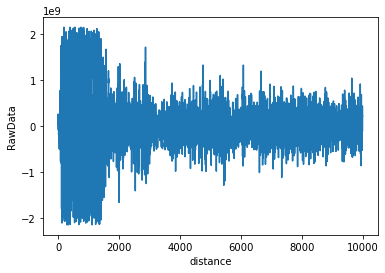

In [41]:
ds.RawData[1000:11000,20000000].plot()

In [33]:
200*60

12000

In [34]:
ds.RawData[:100000,:100000].mean().compute()

<xarray.DataArray 'RawData' ()>
array(1829763.61770255)

In [3]:
ds = xr.open_zarr('/das_data/SouthCable_Tx_2021-11-02T0746142021-11-02T142514/')

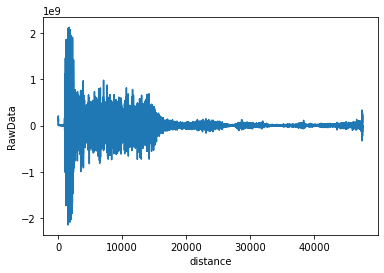

In [9]:
ds.RawData[:,-1].plot()

In [10]:
pd.to_datetime(np.array(ds.RawDataTime[-1]), unit='us')

Timestamp('2021-11-02 01:06:14.829000')

In [9]:
pd.to_datetime(np.array(ds.RawDataTime[0]), unit='us')

Timestamp('2021-11-01 23:11:14.834000')

### Playing with fsspec

- currently RSA server doesn't support range requests
    - see https://github.com/h5py/h5py/issues/2185
- currently in contact with RSA team to inquire if server can be changed to allow range requests

In [1]:
import fsspec

In [4]:
url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231514Z.h5'

In [12]:
of = fsspec.open(url, 'rb')

In [26]:
with of as of1:
    f = h5py.File(of1)
    print(f['Acquisition']['Raw[0]'].keys())

<KeysViewHDF5 ['Custom', 'RawData', 'RawDataTime']>


#### Let's try changing the buffer

In [7]:
fsspec.caching.BytesCache(2000000000)

TypeError: BytesCache.__init__() missing 2 required positional arguments: 'fetcher' and 'size'

### Test modules.convert.h52zarr_xarray

In [5]:
from DASStore.modules import convert
import xarray as xr
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
h5_dir = '/das_data/h5files/'
zarr_dir = '/das_data/test.zarr'

In [4]:
convert.h52zarr_xarray(h5_dir, zarr_dir)

100%|█████████████████████████████████████████████| 3/3 [00:48<00:00, 16.17s/it]


In [6]:
ds = xr.open_zarr(zarr_dir)